In [2]:
import pandas as pd
import spacy

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
from sklearn.metrics import confusion_matrix, classification_report

In [5]:

nlp = spacy.load('en_core_web_sm')
df = pd.read_csv('train.csv')
df_clean = df
df_clean['isToxic'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].any(axis=1).astype(int)
df_clean = df_clean[['comment_text', 'isToxic']].copy()
df_clean.rename(columns={'comment_text': 'Text'}, inplace=True)

## Modèle basé sur un dataframe non équilibré

In [23]:
def treat_comment(comment):
    spacy_comment = nlp(comment, disable=["parser", "tagger", "ner", "textcat"])
    treated_tokens = [w.text for w in spacy_comment if w.is_alpha and not w.is_stop and w.text != 'like']
    return " ".join(treated_tokens)
df_clean['Text'] = df_clean['Text'].map(treat_comment)
df_clean.head()

c:\Users\damie\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Text,isToxic
0,Explanation edits username Hardcore Metallica ...,0
1,matches background colour seemingly stuck Than...,0
2,Hey man trying edit war guy constantly removin...,0
3,real suggestions improvement wondered section ...,0
4,sir hero chance remember page,0


In [21]:
vectorizer1 = TfidfVectorizer()
X = vectorizer1.fit_transform(df_clean['Text'])
Y = df_clean['isToxic']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)
model1 = LogisticRegression()
model1.fit(X_train, Y_train)
y_pred = model1.predict(X_test)
accuracy_score(Y_test, y_pred)

c:\Users\damie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9531246083272754

In [ ]:
print(df_clean['isToxic'].value_counts())

isToxic
0    143346
1     16225
Name: count, dtype: int64


In [ ]:
print(confusion_matrix(Y_test, y_pred))
print(classification_report(y_pred, Y_test))

[[35672   162]
 [ 1708  2351]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     37380
           1       0.58      0.94      0.72      2513

    accuracy                           0.95     39893
   macro avg       0.79      0.94      0.84     39893
weighted avg       0.97      0.95      0.96     39893



## Équilibrage du dataframe

In [24]:
df_toxic = df_clean[df_clean['isToxic'] == 1]
df_non_toxic = df_clean[df_clean['isToxic'] == 0].sample(n=len(df_toxic))
df_equilibre = pd.concat([df_toxic, df_non_toxic])

In [11]:
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform(df_equilibre['Text'])
Y = df_equilibre['isToxic']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
accuracy_score(Y_test, y_pred)

0.8869715271786023

In [12]:
import joblib

In [13]:
joblib.dump(vectorizer2, 'vectorizer.joblib')
joblib.dump(model, 'model.joblib') 

['model.joblib']

In [14]:
matrice = confusion_matrix(Y_test, y_pred)
print(matrice)
print(classification_report(y_pred, Y_test))

[[3712  329]
 [ 588 3484]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      4300
           1       0.86      0.91      0.88      3813

    accuracy                           0.89      8113
   macro avg       0.89      0.89      0.89      8113
weighted avg       0.89      0.89      0.89      8113



In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

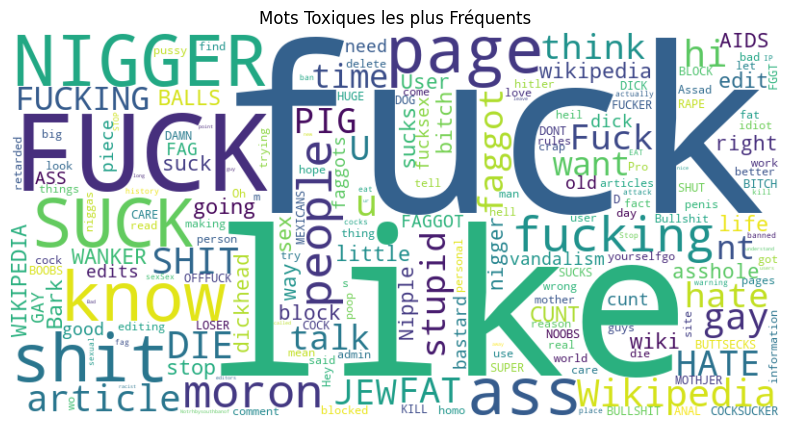

In [19]:
# Compter la fréquence des mots

word_counts = Counter(" ".join(df_toxic['Text']).split())

# # Créer un graphique avec les mots les plus fréquents
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Mots Toxiques les plus Fréquents')
plt.show()